In [1]:
from fastai.vision.all import *
from fastai.data.all import *

In [2]:
DATASET_NAME = 'PLANET'

In [3]:
PROJ_PATH = Path(os.getcwd())
DATA_PATH = PROJ_PATH/'data'
TRAIN_PATH = DATA_PATH/DATASET_NAME/DATASET_NAME
TRAIN_PATH

Path('/home/ubuntu/github/cv_fastai/classification_multilabel/data/PLANET/PLANET')

In [4]:
IMAGES_PATH = TRAIN_PATH/'images'
LABELS_FPATH = TRAIN_PATH/'labels.csv'

In [5]:
df = pd.read_csv(LABELS_FPATH)
df

,image_name,tags
0,train_21983.jpg,partly_cloudy primary
1,train_9516.jpg,clear cultivation primary water
2,train_12664.jpg,haze primary
3,train_36960.jpg,clear primary
4,train_5302.jpg,haze primary road
...,...,...
995,train_1876.jpg,cloudy
996,train_10311.jpg,clear primary road water
997,train_19080.jpg,clear primary
998,train_39339.jpg,clear primary road


In [6]:
fpaths = get_image_files(IMAGES_PATH)
assert len(fpaths) == len(df)

In [7]:
def get_x(row):
    return IMAGES_PATH/(row['image_name'])

def get_y(row):
    return row['tags'].split()

In [8]:
img = Image.open(fpaths[0])
img.size

(256, 256)

In [9]:
if min(img.size) > 1024:
    sz = 1024
elif min(img.size) < 100:
    import warnings
    warnings.warn(f"Image size of {img.size} is very small")
    sz = min(img.size)
else:
    sz = min(img.size)
    
item_tfms_sz = sz
batch_tfms_sz = sz
item_tfms_sz, batch_tfms_sz

(256, 256)

/home/ubuntu/.local/share/virtualenvs/cv_fastai-CUToeN1p/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


torch.Size([16, 3, 256, 256]) torch.Size([16, 17])
TensorImage(-1.9727, device='cuda:0') TensorImage(2.5512, device='cuda:0')
TensorMultiCategory(0., device='cuda:0') TensorMultiCategory(1., device='cuda:0')


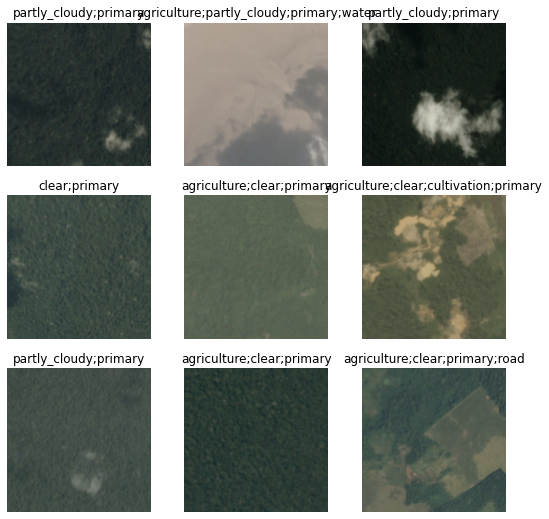

In [10]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       get_x=get_x, 
                       get_y=get_y,
                       item_tfms = Resize(item_tfms_sz),
                       batch_tfms = [*aug_transforms(size=batch_tfms_sz),
                                     Normalize.from_stats(*imagenet_stats)]
                      )

dls = dblock.dataloaders(df, bs=16)
dls.show_batch()
batch = dls.one_batch()
print(batch[0].shape, batch[1].shape)
print(batch[0].min(), batch[0].max())
print(batch[1].min(), batch[1].max())

In [11]:
len(dls.train_ds), len(dls.valid_ds), len(dls.train_ds) + len(dls.valid_ds)

(800, 200, 1000)

In [12]:
f1samples = FBetaMulti(beta=1,average='samples',thresh=0.2)
metrics = [partial(accuracy_multi, thresh=0.2), f1samples]

In [13]:
pickle_fpath = TRAIN_PATH/'export_learn_obj.pkl'
learn = cnn_learner(dls, resnet50, metrics=metrics)

if (pickle_fpath).exists():
    learn = load_learner(pickle_fpath)
    learn.dls = dls
else:
    learn.fine_tune(8)
    learn.export(fname=pickle_fpath)

/home/ubuntu/.local/share/virtualenvs/cv_fastai-CUToeN1p/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


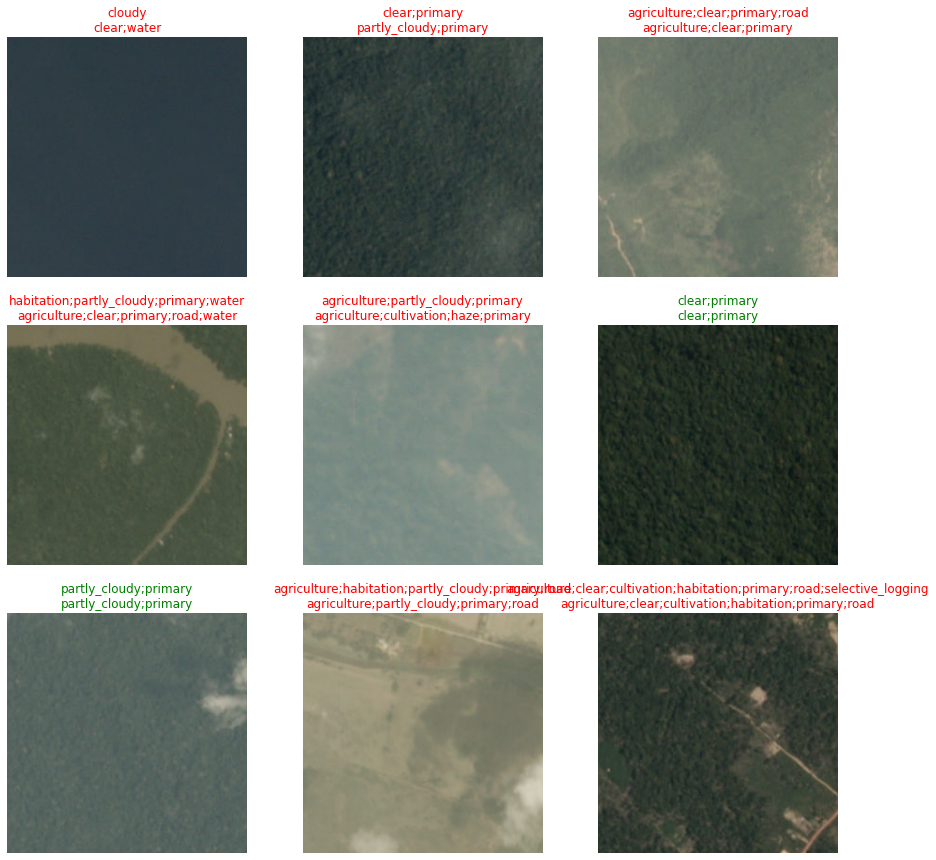

In [14]:
learn.show_results(figsize=(15,15))

In [15]:
loss_val, acc_val, f1_val = learn.validate()
loss_val, acc_val, f1_val 

(0.1299719512462616, 0.9526470303535461, 0.8846885059385059)

In [16]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_top_losses(12)